In [5]:
%pip install torch torchvision matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\tsbh0\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [14]:
import torch
import torchvision
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


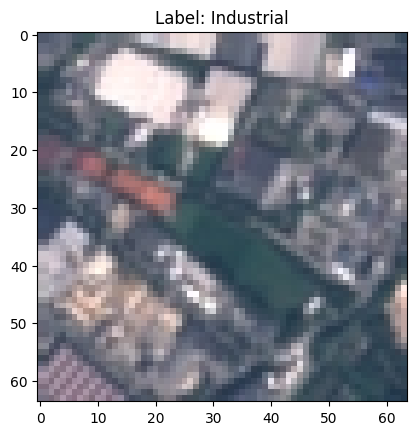

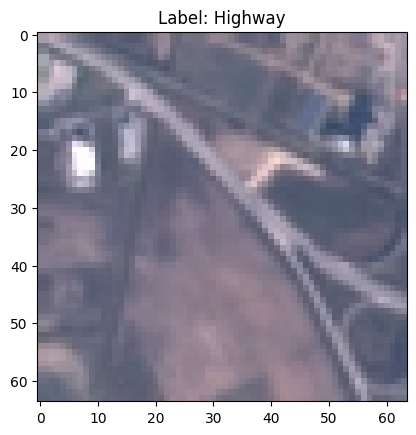

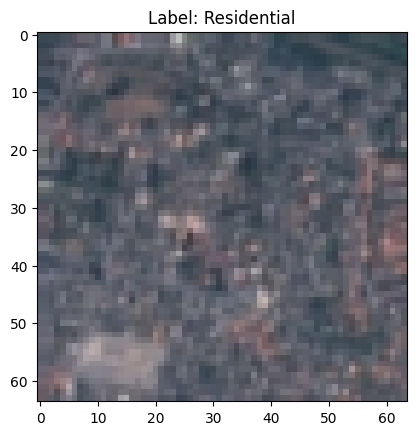

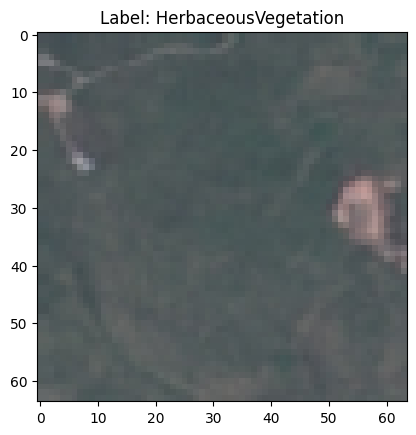

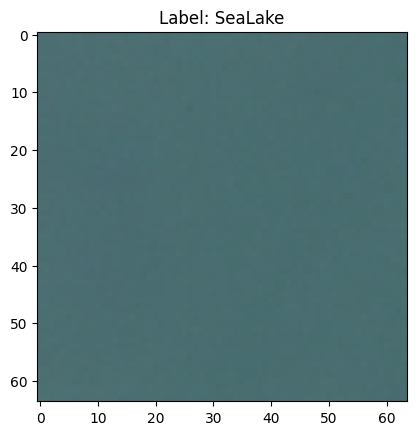

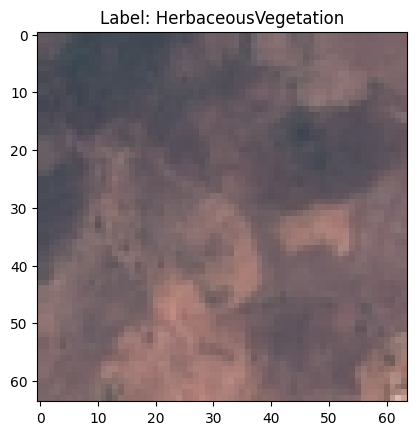

In [15]:
# Load the Oxford Pets dataset
dataset = datasets.EuroSAT("../data", download=True)

classes = dataset.classes
print(classes)

img_count = len(dataset.imgs)
# Print 6 random images
for _ in range(6):
  index = np.random.choice(img_count, replace=False)
  plt.imshow(dataset[index][0])
  plt.title(f"Label: {classes[dataset[index][1]]}")
  plt.show()